In [1]:
from pathlib import Path
import pickle
import sys
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text

ROOT = Path.cwd().parent 
sys.path.insert(0, str(ROOT))
from playstyle_utils import standardized, home_vs_away, split_matches, total_variation_distance, aitchison_mean, make_show_plot, plot_club_styles

DATA = ROOT / "data" / "derived"

with open(DATA / "movement_chain_clusters.pkl", "rb") as f:
    movement_chain_clusters = pickle.load(f)

with open(DATA / "lda_model.pkl", "rb") as f:
    lda_model = pickle.load(f)

with open(DATA / "corpus_train.pkl", "rb") as f:
    corpus_train = pickle.load(f)

with open(DATA / "df_matches.pkl", "rb") as f:
    df_matches = pickle.load(f)

with open(DATA / "team_mapping.pkl", "rb") as f:
    team_name_mapping = pickle.load(f)

Our goal is to quantify playing styles in a way that is both **interpretable** and **useful for further analysis**. 
For each team and match, we obtain a **distribution over playing-style categories**, which enables the study of both **team-specific** and **match-specific** patterns in a coherent framework.

To illustrate the types of insights these distributions can provide, we present some applications using only **basic visualizations** and **descriptive statistics**.

In [2]:
topic_distributions_data = {}

for i in movement_chain_clusters:
    topic_distributions_data[i] = None

all_distributions = []
for i in lda_model.get_document_topics(corpus_train, minimum_probability=1e-8):
    all_distributions.append(i)

In [3]:
for idx, club in enumerate(topic_distributions_data):
    topic_distributions_data[club] = all_distributions[idx]

In [ ]:
# Get the playing style (topic) distribution per match

for name in topic_distributions_data:
    short_distribution = []
    for i in topic_distributions_data[name]:
        short_distribution.append(i[1])

    topic_distributions_data[name] = short_distribution

topic_distributions_data

In [17]:
topic_distributions_data

{'2576335_Internazionale': [0.0012094205,
  0.17979448,
  0.61645275,
  0.07945889,
  0.0012118679,
  0.12187263],
 '2576335_Lazio': [0.28084177,
  0.0060167145,
  0.005991616,
  0.006003698,
  0.6951065,
  0.0060396893],
 '2576336_Sassuolo': [0.004221971,
  0.13910006,
  0.0042036474,
  0.004201012,
  0.62337184,
  0.2249015],
 '2576336_Roma': [0.0014290472,
  0.0014286067,
  0.382359,
  0.15920055,
  0.08206213,
  0.37352064],
 '2576329_Cagliari': [0.4513996,
  0.005988088,
  0.006031055,
  0.00603421,
  0.0060214913,
  0.5245256],
 '2576329_Atalanta': [0.0017235407,
  0.28771892,
  0.0017199087,
  0.0017209662,
  0.20381291,
  0.50330377],
 '2576330_Benevento': [0.27115047,
  0.3118621,
  0.00091478834,
  0.41424146,
  0.0009147351,
  0.00091647246],
 '2576330_Chievo': [0.0058082733,
  0.0058152205,
  0.37467873,
  0.0058136056,
  0.6020623,
  0.005821913],
 '2576331_Udinese': [0.0026764595,
  0.0026694024,
  0.0026751894,
  0.45743883,
  0.0026705696,
  0.53186953],
 '2576331_Bolog

In [ ]:
groups = defaultdict(list)
for key, values in topic_distributions_data.items():
    club = key.split('_')[1]
    groups[club].append(values)

groups

In [6]:
club_style_distributions = {}
for club, mat in groups.items():
    club_style_distributions[club] = aitchison_mean(mat)

club_style_distributions

{'Internazionale': array([0.30283707, 0.1444943 , 0.28099342, 0.10750579, 0.09889979,
        0.06526963]),
 'Lazio': array([0.05670389, 0.31781795, 0.0958174 , 0.02504194, 0.35544617,
        0.14917265]),
 'Sassuolo': array([0.34141643, 0.2651475 , 0.05245265, 0.08522088, 0.12571771,
        0.13004484]),
 'Roma': array([0.06918328, 0.24242297, 0.11507214, 0.08559024, 0.37238023,
        0.11535114]),
 'Cagliari': array([0.18659872, 0.06384854, 0.17188696, 0.09518741, 0.07528112,
        0.40719725]),
 'Atalanta': array([0.03613101, 0.31794765, 0.00665935, 0.24289928, 0.15211396,
        0.24424875]),
 'Benevento': array([0.0838222 , 0.16937321, 0.06314685, 0.16817437, 0.04299455,
        0.47248882]),
 'Chievo': array([0.22749939, 0.06847763, 0.10995649, 0.0795817 , 0.15728692,
        0.35719787]),
 'Udinese': array([0.1067448 , 0.09740744, 0.11119383, 0.34213536, 0.10748332,
        0.23503525]),
 'Bologna': array([0.07669598, 0.11150453, 0.15468437, 0.32804188, 0.12485289,
      

### Champions vs. Last Place 

To compare playing styles within and between leagues, we contrast the league champions with the teams finishing in last place. 
We also highlight, for each league, the team with the most *unique* playing style as measured by the uniqueness metric in Eq. (\ref{uniqueness}).

The results are shown below. While the champions share several similarities across leagues, there are also clear differences. In particular, the French champions **Paris Saint-Germain** exhibit a distinct profile, relying more on **midfield play** and playing **less high up the pitch** than the other champions. Additionally, the Italian champions **Juventus** show a stronger tendency toward **playing low** compared to the other league winners.

In contrast, the playing styles of the teams finishing last vary more across leagues. Comparing both figures highlights substantial differences between champions and bottom-ranked teams, especially in the extent to which teams **play high up the field**. Because our playing-style measures are derived from *observed possession sequences*, they primarily reflect what teams were able to execute in possession rather than their underlying intentions. Consequently, stronger teams are expected to display more of the **play-high** style, while weaker teams may rely more on **play-low** patterns. Finally, tactical behavior during **non-possession** phases is not observed in our data and is therefore not directly captured by these style measures.

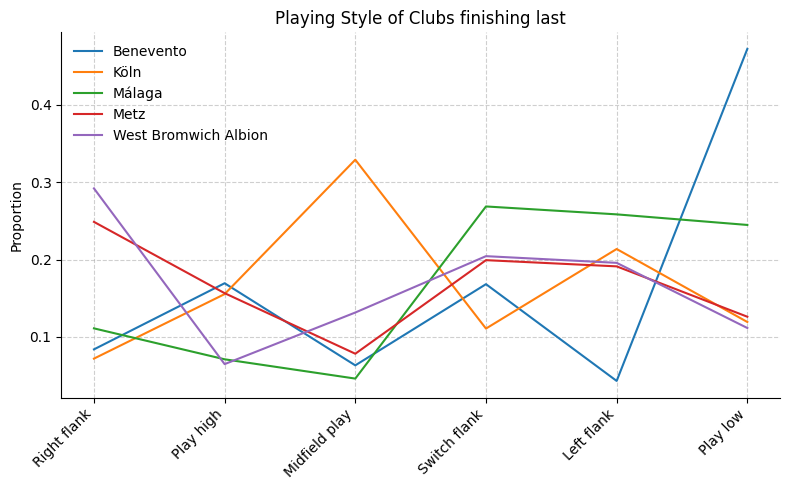

In [7]:
categories = ["Right flank", "Play high", "Midfield play", "Switch flank", "Left flank", "Play low"]

plot_club_styles(
    club_style_distributions,
    teams_to_plot=['Benevento','Köln','Málaga','Metz','West Bromwich Albion'],
    categories=categories,
    title="Playing Style of Clubs finishing last")


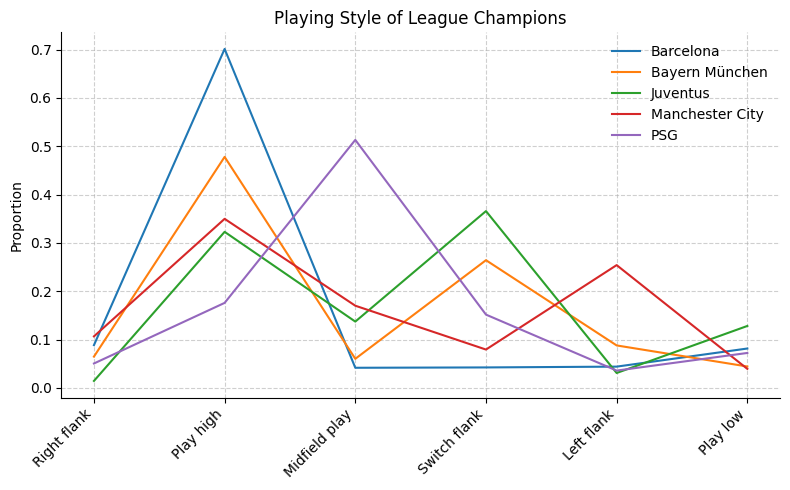

In [8]:
plot_club_styles(
    club_style_distributions,
    teams_to_plot=['Barcelona','Bayern München','Juventus','Manchester City','PSG'],
    categories=categories,
    title="Playing Style of League Champions")

### Uniqueness and consistency of team playing styles

For each match, we estimate a playing-style distribution for both teams. These distributions summarize how frequently different ball-movement patterns occur, and can be inspected to understand how playing styles vary across teams and match contexts. To facilitate team-level comparisons, we define two summary measures—**uniqueness** and **consistency**..

Let $\bar{\theta}_t$ denote the **Aitchison mean** playing-style vector of team $t$, and let $\theta_{t,m}$ be the style vector observed for team $t$ in match $m$.

- **Uniqueness** $U_t$ measures how distinct a team’s average style is relative to the other teams. We define it as the average dissimilarity between $\bar{\theta}_t$ and the Aitchison mean styles of all other teams:
  
$$
U_{t} = \frac{1}{T-1}\sum_{t\neq t'}^{T} D\left(\bar{\theta}_{t}, \bar{\theta}_{t'}\right),
\tag{1}\label{uniqueness}
$$

- **Consistency** $C_t$ measures how stable a team’s style is from game to game. We define it based on the average dissimilarity between all pairs of match-level style vectors:
  
$$
C_{t} =
\frac{1}{1 + \frac{2}{M_{t}(M_{t} - 1)}\sum_{1 \le m < n \le M_{t}}
D\left(\theta_{t,m}, \theta_{t,n}\right)}.
\tag{2}
$$

Here, $T$ is the number of teams in the competition, $M_t$ is the number of observed matches for team $t$, and $D(p,q)$ denotes the **total variation distance** between distributions $p$ and $q$.

In the figure below, we plot the **uniqueness** and **consistency** of Premier League teams in the 2017/18 season after standardizing both measures to **z-scores**. Values above (below) zero indicate above-average (below-average) performance on each axis.

In [9]:
# Split the dictionary by competition using predefined team lists
serie_a_teams = {"Lazio", "Internazionale", "Roma", "Sassuolo", "Cagliari", "Atalanta", "Chievo", "Benevento", "Bologna", "Udinese", "Crotone", "Napoli", "Milan", "Fiorentina", "Sampdoria", "SPAL", "Torino", "Genoa", "Juventus", "Hellas Verona"}

premier_league_teams = {"Burnley", "AFC Bournemouth", "Crystal Palace", "West Bromwich Albion", "Arsenal", "Huddersfield Town", "Brighton & Hove Albion", "Liverpool", "Watford", "Manchester United", "Newcastle United", "Chelsea", "Manchester City", "Southampton", "Swansea City", "Stoke City", "Leicester City", "Tottenham Hotspur", "Everton", "West Ham United"}

la_liga_teams = {"Barcelona", "Real Sociedad", "Atlético Madrid", "Eibar", "Espanyol", "Athletic Club", "Valencia", "Deportivo La Coruña", "Real Madrid", "Villarreal", "Deportivo Alavés", "Sevilla", "Getafe", "Málaga", "Las Palmas", "Girona", "Real Betis", "Leganés", "Celta de Vigo", "Levante"}

ligue1_teams = {"Caen", "PSG", "Dijon", "Angers", "Olympique Lyonnais", "Nice", "Olympique Marseille", "Amiens SC", "Bordeaux", "Metz", "Strasbourg", "Nantes", "Montpellier", "Rennes", "Saint-Étienne", "Lille", "Toulouse", "Guingamp", "Troyes", "Monaco"}

bundesliga_teams = {"Bayern München", "Stuttgart", "Hoffenheim", "Borussia Dortmund", "Hertha BSC", "RB Leipzig", "Freiburg", "Augsburg", "Schalke 04", "Eintracht Frankfurt", "Hannover 96", "Bayer Leverkusen", "Borussia M'gladbach", "Hamburger SV", "Werder Bremen", "Mainz 05", "Wolfsburg", "Köln"}

# Now split the full dictionary into five dictionaries
serie_a_dict = {team: vec for team, vec in club_style_distributions.items() if team in serie_a_teams}
premier_league_dict = {team: vec for team, vec in club_style_distributions.items() if team in premier_league_teams}
la_liga_dict = {team: vec for team, vec in club_style_distributions.items() if team in la_liga_teams}
ligue1_dict = {team: vec for team, vec in club_style_distributions.items() if team in ligue1_teams}
bundesliga_dict = {team: vec for team, vec in club_style_distributions.items() if team in bundesliga_teams}

In [10]:
premier_league_dict

{'AFC Bournemouth': array([0.04440549, 0.11160469, 0.02036848, 0.05651691, 0.25119506,
        0.51590936]),
 'Burnley': array([0.0972538 , 0.05263006, 0.35885019, 0.20094923, 0.21290434,
        0.07741238]),
 'Crystal Palace': array([0.15720573, 0.23298065, 0.09819309, 0.0753655 , 0.38164103,
        0.05461399]),
 'West Bromwich Albion': array([0.29209259, 0.06475365, 0.13149915, 0.20441344, 0.19576393,
        0.11147724]),
 'Huddersfield Town': array([0.38606853, 0.04872195, 0.09406152, 0.1690459 , 0.21668707,
        0.08541503]),
 'Arsenal': array([0.05612895, 0.723135  , 0.03408892, 0.06157457, 0.04139085,
        0.08368171]),
 'Liverpool': array([0.07032236, 0.39165988, 0.28407891, 0.18308112, 0.05676664,
        0.01409109]),
 'Brighton & Hove Albion': array([0.08893792, 0.03215471, 0.04270626, 0.34224079, 0.10622927,
        0.38773105]),
 'Manchester United': array([0.066115  , 0.29195702, 0.15538483, 0.07164819, 0.27705385,
        0.1378411 ]),
 'Watford': array([0.39980

In [11]:
#uniqueness
import math

def Sort(sub_li):
    sub_li.sort(key = lambda x: x[2])
    return sub_li

choose_competition = premier_league_dict
uniqueness = []
for j in choose_competition:
    this_club = j
    similar_teams_hellinger_dist = []
    for i in choose_competition:
        if i == this_club:
            continue
        else:
            similar_teams_hellinger_dist.append([this_club,i, total_variation_distance(np.array(choose_competition[i]), np.array(choose_competition[this_club]))])

    structure = Sort(similar_teams_hellinger_dist)
    similar_clubs = [similar_club[1] for similar_club in structure]
 
    result = dict((k, choose_competition[k]) for k in similar_clubs if k in choose_competition)
    result = result.values()
    result = np.asarray(list(result), dtype=float) 
    style = aitchison_mean(result)
    uniqueness.append([this_club, total_variation_distance(np.array(choose_competition[this_club]), np.array(style))])
    

In [12]:
#Consistency

consistency = []

for j in uniqueness:
  consitency_list = []
  for i in topic_distributions_data:
    if i.split('_')[1] == j[0]:
      consitency_list.append(np.array(topic_distributions_data[i]))

  res = [(a, b) for idx, a in enumerate(consitency_list) for b in consitency_list[idx + 1:]]

  dists = [total_variation_distance(a, b) for a,b in res]
  mean_pairwise = np.mean(dists) 
  consistency.append([j[0], 1 / (1 + mean_pairwise)]) 

In [13]:
standardized_uniqueness = standardized(uniqueness, premier_league_dict.keys())
standardized_consistency = standardized(consistency, premier_league_dict.keys())

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


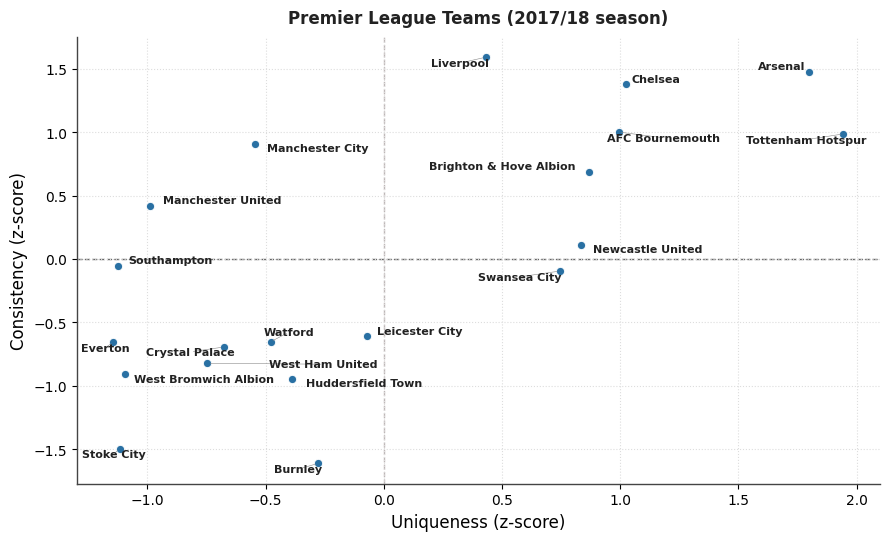

In [14]:
from adjustText import adjust_text

df_c = pd.DataFrame(standardized_consistency, columns=['Club', 'Consistency_z'])
df_u = pd.DataFrame(standardized_uniqueness, columns=['Club', 'Uniqueness_z'])
metrics = pd.merge(df_u, df_c, on='Club', how='inner')

x = metrics['Uniqueness_z']
y = metrics['Consistency_z']

plt.rcParams.update({
    'pdf.fonttype': 42, 'ps.fonttype': 42,
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial', 'Helvetica'],
    'axes.labelsize': 12,
    'axes.titlesize': 16,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.edgecolor': '#444444',
    'axes.linewidth': 1.0,
    'figure.facecolor': 'white',
    'text.color': '#222222',
})

fig, ax = plt.subplots(figsize=(9, 6))

ax.scatter(
    x, y,
    facecolor="#126199",
    edgecolor='white',
    linewidth=0.8,
    alpha=0.9,
    zorder=3,
)

x_mean, y_mean = x.mean(), y.mean()
ax.axvline(x_mean, color="#BDB6B6", linestyle='--', linewidth=1, zorder=1)
ax.axhline(y_mean, color='#666666', linestyle='--', linewidth=1, zorder=1)

texts = []
for _, row in metrics.iterrows():
    texts.append(ax.text(row['Uniqueness_z'], row['Consistency_z'],
                         row['Club'], fontsize=8, ha='center', va='center',
                         weight='bold', zorder=4))

adjust_text(
    texts, ax=ax,
    arrowprops=dict(arrowstyle='-', color='#888888', lw=0.4),
    expand_points=(1.3, 1.3), expand_text=(1.3, 1.3),
    force_points=0.25, force_text=0.25, precision=0.5,
)

ax.grid(True, linestyle=':', linewidth=0.8, color='#DDDDDD', zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Uniqueness (z-score)')
ax.set_ylabel('Consistency (z-score)')
ax.set_title('Premier League Teams (2017/18 season)', weight = 'bold', pad = 10, fontsize=12)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



### Home vs. away differences in team playing styles

To assess whether teams adopt different playing styles when playing **at home** versus **away**, we compare the average play-style distributions estimated from each team’s home matches to those estimated from its away matches.

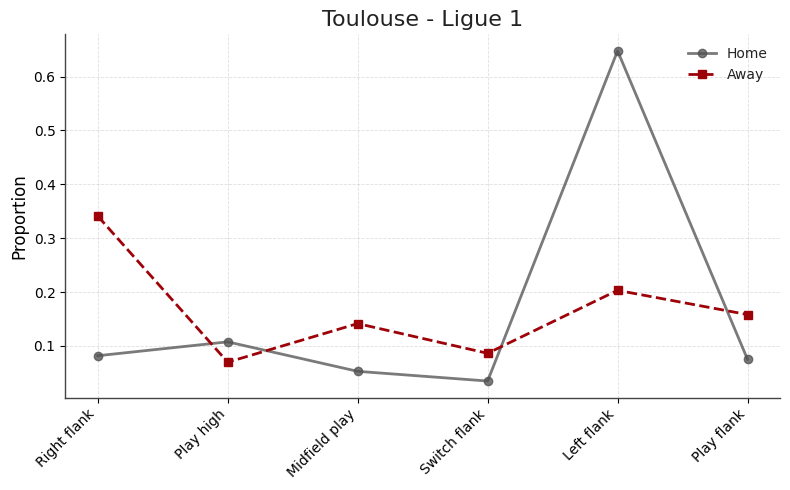

In [15]:
categories = ["Right flank", "Play high", "Midfield play", "Switch flank", "Left flank", "Play flank"]


# change club name 
team = "Toulouse"
styles = home_vs_away(team, df_matches, topic_distributions_data)
show_plot = make_show_plot(df_matches, topic_distributions_data)
show_plot(team, styles, categories)


### Within-season changes in team playing styles: coach effects

Because we observe all matches within a season, we can study whether a team’s playing style changes over time. One approach is to compare a team’s average style early in the season with its average style toward the end. Another approach is to examine potential **coach effects** by comparing average playing styles **before** and **after** a coaching change.

To illustrate this idea, we focus on **Borussia Dortmund** during the **2017/2018** season and compare their estimated play-style distributions around the coach termination date. 

Borussia Dortmund started the 2017/18 season under **Peter Bosz**, using a high-pressing **4–3–3** with a very high defensive line and aggressive midfield positioning to sustain possession and territory high up the pitch. This approach emphasized **tempo, width, and flank progression**, enabling wide overloads and quick entries into the final third. After an **eight-match winless Bundesliga run**, Bosz was dismissed following a **2–1 home loss to Werder Bremen on 9 December 2017**, and **Peter Stöger** took over.

Although Stöger kept a nominal **4–3–3**, he implemented a clear tactical overhaul: Dortmund became **more compact** and defended from a **deeper block** rather than pressing relentlessly. In possession, buildup became **more controlled** and was more often routed through the **wings**, with increased use of **diagonal balls** and **cross-field switches**.

These changes are reflected in Figure \ref{fig:dortmund}. The switch from Bosz to Stöger corresponds to a **sharp decline in “play high”**, a **modest increase in “midfield play,”** and noticeable rises in **left flank**, **right flank**, and **switch flank** styles. The **“play low”** proportion remains roughly unchanged, suggesting the key difference lies in how Dortmund progressed after regaining possession—**more wide circulation and flank switching under Stöger**, rather than sustained possession high in the opponent’s half.

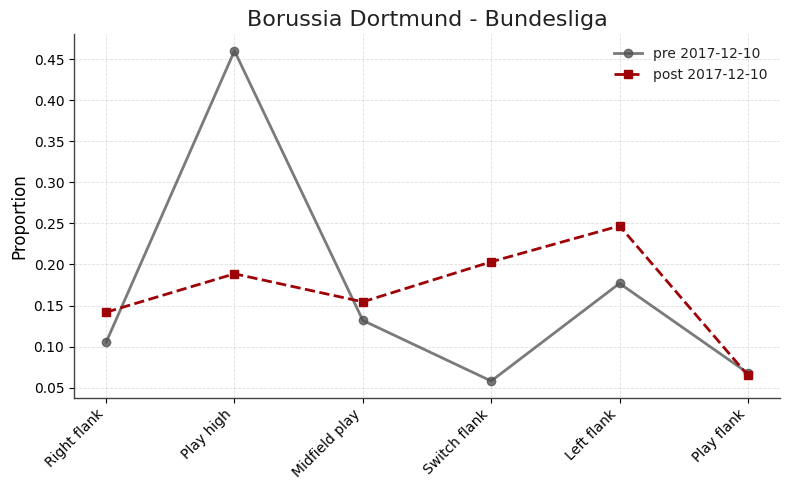

In [16]:
team = "Borussia Dortmund"
date = "2017-12-10"
pre_and_post_style = split_matches(team, date, df_matches, topic_distributions_data)
show_plot = make_show_plot(df_matches, topic_distributions_data)
show_plot(team, pre_and_post_style, categories, date = "2017-12-10")